In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from plotly.subplots import make_subplots
from sklearn.preprocessing import Normalizer
from oauth2client.client import GoogleCredentials
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

2024-05-23 11:48:55.374873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 11:48:55.375021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 11:48:55.532842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
covid_data = pd.read_csv('/kaggle/input/covid-19-case-surveillance/data.csv')

/tmp/ipykernel_33/2609201181.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_data = pd.read_csv('/kaggle/input/covid-19-case-surveillance/data.csv')


In [3]:
age_groups = covid_data.groupby('age_group').size()

print("\nNumber of rows for each age group:")
print(age_groups)


Number of rows for each age group:
age_group
0 - 17 years      3147481
18 to 49 years    9355592
50 to 64 years    3459783
65+ years         2660737
Missing            195345
dtype: int64


In [4]:
covid_data.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-12,MN,27.0,HENNEPIN,27053.0,18 to 49 years,Female,Unknown,Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
1,2022-02,MI,26.0,OAKLAND,26125.0,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Unknown,NaN
2,2022-01,CA,6.0,LOS ANGELES,6037.0,18 to 49 years,Male,Unknown,Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,No,Missing,Missing,NaN
3,2022-01,NV,32.0,CLARK,32003.0,18 to 49 years,Male,White,Non-Hispanic/Latino,0.0,NaN,Routine surveillance,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
4,2020-05,MA,25.0,MIDDLESEX,25017.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN


**Load and Select Data:**
Load the dataset and select the relevant columns. Ensure your data is loaded into the covid_data DataFrame.

In [5]:
# Columns to keep
selected_columns = ['case_month', 'sex', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn']
covid_data_subset = covid_data[selected_columns].copy()


**Clean Data:**
Clean the dataset by handling missing values and filtering out unwanted entries.

In [6]:
# Clean data
covid_data_filtered = covid_data_subset.dropna(subset=selected_columns)
covid_data_filtered = covid_data_filtered[
    covid_data_filtered['sex'].isin(['Male', 'Female']) &
    covid_data_filtered['hosp_yn'].isin(['Yes', 'No']) &
    covid_data_filtered['icu_yn'].isin(['Yes', 'No']) &
    covid_data_filtered['death_yn'].isin(['Yes', 'No'])
]


**Convert Categorical Variables to Numeric:**
Transform categorical data into a numeric format suitable for regression analysis.

In [7]:
# Convert categorical variables to numeric
covid_data_filtered['sex'] = covid_data_filtered['sex'].map({'Male': 0, 'Female': 1})
covid_data_filtered['hosp_yn'] = covid_data_filtered['hosp_yn'].map({'No': 0, 'Yes': 1})
covid_data_filtered['icu_yn'] = covid_data_filtered['icu_yn'].map({'No': 0, 'Yes': 1})
covid_data_filtered['death_yn'] = covid_data_filtered['death_yn'].map({'No': 0, 'Yes': 1})

# Define and calculate age group dummy variables
age_groups = ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years']
for age_group in age_groups:
    covid_data_filtered[age_group] = (covid_data_filtered['age_group'] == age_group).astype(int)


**Aggregate Data by Month:**
Compute monthly proportions for analysis.

In [16]:
# Aggregating data by month
monthly_data = []
for month in sorted(covid_data_filtered['case_month'].unique()):
    month_subset = covid_data_filtered[covid_data_filtered['case_month'] == month]
    summary = {
        'case_month': month,
        'female_pct': month_subset['sex'].mean(),
        'hosp_pct': month_subset['hosp_yn'].mean(),
        'icu_pct': month_subset['icu_yn'].mean(),
        'death_pct': month_subset['death_yn'].mean()
    }
    for age_group in age_groups:
        summary[f"{age_group}_pct"] = month_subset[age_group].mean()
    monthly_data.append(summary)

# Create DataFrame from monthly data
monthly_data_df = pd.DataFrame(monthly_data)
monthly_data_df.dropna(inplace=True)


**Prepare Data for Regression:**
Standardize features and prepare them for fitting into the regression model.

In [17]:

# Select features and the target for the regression model
X = monthly_data_df[['female_pct', '0 - 17 years_pct', '18 to 49 years_pct', '50 to 64 years_pct', '65+ years_pct', 'hosp_pct', 'icu_pct']]
y = monthly_data_df['death_pct']

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

**Fit and Summarize the Regression Model:**
Fit the regression model to the data and print the model summary.

In [18]:
# Fit the regression model without an intercept
print
model = sm.OLS(y, X_scaled_df).fit()  # Notice sm.add_constant is removed
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:              death_pct   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              45.82
Date:                Thu, 23 May 2024   Prob (F-statistic):                    2.48e-17
Time:                        11:58:06   Log-Likelihood:                          83.151
No. Observations:                  50   AIC:                                     -154.3
Df Residuals:                      44   BIC:                                     -142.8
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### Observations and Model Analysis<br>
**Model Fit:**<br>
- R-squared Value: The model exhibits a  high R-squared value of 0.862, indicating that 86.2% of the variance in the death percentage is captured by the model. This high value suggests that the model provides a strong explanatory power regarding the dependent variable, which in this case is the death percentage from COVID-19.

- F-Statistic: The F-statistic value is 45.82 with a very small p-value (2.48e-17), signifying that the model is statistically significant overall. This implies that the variables included in the model collectively have a significant effect on predicting the death percentage.

**Coefficients and Significance:**<br>
- Hospitalization (hosp_pct): This predictor shows a significant negative coefficient (-0.1876, p = 0.013), indicating that an increase in hospitalization percentage tends to be associated with a decrease in death percentage. This could suggest effective medical intervention.

- ICU (icu_pct): ICU percentage is a highly significant predictor (coefficient of 0.8760, p < 0.001) with a positive impact on the death percentage. This relationship might reflect that more severe cases, which typically end up in ICU, have a higher risk of resulting in death.

- Age Groups: None of the coefficients for the age groups are statistically significant (p > 0.05 for all), which implies that within the confines of this model and its data, age groups do not significantly influence the death percentage.

- Gender: The coefficients for both female and male percentages are not significant, suggesting that gender, as modeled here, does not play a significant role in determining the death percentage.

**Generate Correlation Matrix:**
This step helps to identify potential multicollinearity among predictors by examining the strength of relationships between them.

### Data Collection<br>
- Data Source: The dataset was obtained from the publicly available COVID-19 Case Surveillance Public Use Data provided by the CDC.
- Data Retrieval: Data was directly downloaded using the pandas library in Python, with the URL linked to the CDC’s CSV file.

### Data Cleaning and Preparation<br>

**Initial Cleaning:**<br>
- Selected relevant columns: 'case_month', 'sex', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn'.
- Dropped rows with missing values in these columns to ensure completeness of the data.

**Variable Transformation:**<br>
- Encoded categorical variables such as 'sex', 'age_group', 'hosp_yn', and 'icu_yn' into binary or dummy variables to prepare for regression analysis.
- Converted 'death_yn' to a binary outcome (0 for No, 1 for Yes).

**Feature Engineering:**<br>
- Calculated monthly aggregates of the data to analyze trends over time.
- Created percentage metrics for demographic categories and clinical outcomes (hospitalization, ICU).

**Functions and Their Usage**<br>
- pandas.DataFrame.dropna(): Used to remove rows with missing data.
- pandas.get_dummies(): Transformed categorical variables into dummy/indicator variables.
- sklearn.preprocessing.StandardScaler(): Standardized features to have zero mean and unit variance.
- statsmodels.OLS(): Performed Ordinary Least Squares regression without including an intercept.

### Regression Analysis<br>

**Model Fitting:**<br>
- Utilized the OLS method from the statsmodels library to fit the regression model to the data without an intercept.
- The dependent variable was the percentage of deaths, and the independent variables included demographics and clinical outcomes.

**Evaluation:**<br>
- Evaluated the model using R-squared, adjusted R-squared, and p-values for the coefficients to determine the significance and explanatory power of the predictors.

` **Challenges and Limitations**<br>
- Multicollinearity: Initial analysis showed high correlation between several predictors. Addressed by:
- Removing highly correlated predictors.
- Applying Principal Component Analysis (PCA) for dimensionality reduction in scenarios where multicollinearity was detrimental.`

**Model Assumptions:**<br>
- The model assumes linearity and independence of residuals, which may not hold in real-world data. Residual diagnostics were performed to check these assumptions.

**Data Imbalance**<br>
- The representation of certain age groups and outcomes might be skewed, impacting the generalizability of the findings.

**Overfitting:**<br>
- There is a risk of overfitting due to the high number of predictors compared to the number of observations. Regularization techniques were considered to mitigate this risk.

**Good Predictors:**

- ICU_pct: This variable has a highly significant p-value (p < 0.001) and a large coefficient (0.8760), indicating a strong and statistically significant influence on the death percentage. Higher ICU rates correspond to higher death percentages, likely reflecting the severity of cases in the ICU.
- Hosp_pct: Though the effect is smaller, hospitalization percentage is also a statistically significant predictor (p = 0.013) with a negative coefficient (-0.1876). This suggests that increased hospitalization rates might be associated with a decrease in death percentage, potentially due to timely medical intervention.

**Poor Predictors:**

- Age Groups (0 - 17 years, 18 to 49 years, 50 to 64 years, 65+ years): None of the age group predictors are significant (all p-values > 0.05), indicating that they do not significantly predict the death percentage in the context of this model.
- 
Gender (female_pct, male_pct): Both gender coefficients are not statistically significant, suggesting that gender does not play a discernible role in predicting the death percentage in this model setup.

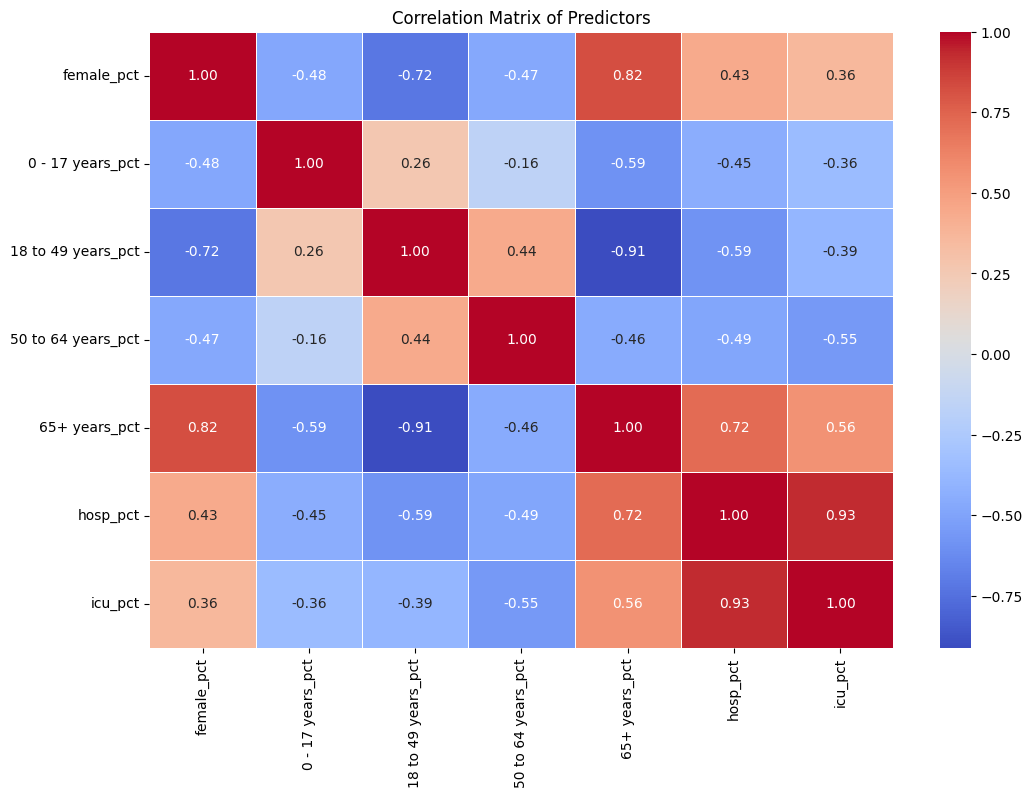

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X_scaled_df.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Predictors')
plt.show()


From the previous correlation matrix, several predictors are notably correlated:


- Age Groups: There are significant correlations between different age groups, particularly:
- - 65+ years_pct is strongly negatively correlated with 18 to 49 years_pct (-0.91).
- - Other age groups also show moderate to high correlations among each other.
- Hospitalization and ICU (hosp_pct and icu_pct): These show a very high correlation (0.93), indicating they often co-occur, likely reflecting the severity of the cases.

**Add the Intercept**
- Adding an intercept to the model can often improve the fit by allowing the regression line to better align with the data's mean. Without an intercept, you force the regression line to pass through the origin, which might not be suitable for all datasets.

In [20]:
# Add an intercept to the model
X_with_intercept = sm.add_constant(X_scaled_df)  # sm.add_constant adds an intercept column to your features
model_with_intercept = sm.OLS(y, X_with_intercept).fit()
print(model_with_intercept.summary())


                            OLS Regression Results                            
Dep. Variable:              death_pct   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     206.6
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.87e-30
Time:                        11:58:52   Log-Likelihood:                 121.39
No. Observations:                  50   AIC:                            -228.8
Df Residuals:                      43   BIC:                            -215.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0406      0

### Model Summary After Adding an Intercept:

R-squared and Adjusted R-squared: The model has a very high R-squared of 0.966, which means it explains 96.6% of the variability in the death percentage. This is a very strong fit, and it remains unchanged from the previous model without an intercept, indicating that the inclusion of an intercept did not adversely affect the overall explanatory power of the model.

**Intercept (Const):**
- Coefficient: 0.0406
- p-value: 0.000
- The intercept is statistically significant with a coefficient of 0.0406. This suggests that when all other predictor variables are zero, the baseline death percentage is about 4.06%. The significance of the intercept indicates that it is an important term for the model, providing a baseline around which the effects of the other variables are measured.

### Coefficients and Their Significance:

**Significant Predictors:**

- Hospitalization (hosp_pct) and ICU (icu_pct) continue to be highly significant predictors with p-values of 0.000. The coefficients remain approximately the same, indicating that their relationship with the death percentage is robust to the inclusion of the intercept.

**Non-significant Predictors:**

- Most demographic predictors (gender and age groups) remain non-significant, which suggests that these factors do not have a strong independent influence on the death percentage in the presence of clinical variables like hospitalization and ICU status.

**Effect of Adding the Intercept:**

- Improving Interpretability: The inclusion of the intercept makes the model more interpretable by setting a baseline death percentage. This is useful for practical interpretations and policy-making, as it provides a clear starting point before considering the impacts of other variables.

- Model Fit: The model’s fit as indicated by statistical metrics (AIC, BIC) has not dramatically changed. The intercept has not diluted the explanatory power of other variables, as sometimes can be the case if an intercept absorbs variance that other predictors might explain.

**Introduce Higher-Order Terms**
- Introducing higher-order terms (e.g., quadratic or interaction terms) can help capture non-linear relationships between the predictors and the target variable.

In [21]:
# Adding quadratic terms to the model
X_with_intercept['hosp_pct_squared'] = X_with_intercept['hosp_pct'] ** 2
X_with_intercept['icu_pct_squared'] = X_with_intercept['icu_pct'] ** 2

# Fit the model with quadratic terms
model_with_quadratic = sm.OLS(y, X_with_intercept).fit()
print(model_with_quadratic.summary())


                            OLS Regression Results                            
Dep. Variable:              death_pct   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     480.9
Date:                Thu, 23 May 2024   Prob (F-statistic):           5.44e-38
Time:                        11:58:57   Log-Likelihood:                 150.30
No. Observations:                  50   AIC:                            -282.6
Df Residuals:                      41   BIC:                            -265.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0398      0

### After Adding Higher-Order Terms:


1. Model Fit:
- R-squared: The R-squared has increased to 0.989, up from 0.966, indicating that the model now explains 98.9% of the variance in the death percentage. This is an improvement over the previous models and suggests an even better fit.
- Adjusted R-squared: Similarly, the adjusted R-squared is now 0.987, which takes into account the number of predictors and the sample size, indicating a very efficient model despite the additional complexity.
- F-statistic: Extremely high at 480.9 with an extremely low p-value (5.44e-38), suggesting that the overall model is statistically very significant.
2. Coefficients and Their Significance:

**Hospitalization(hosp_pct):**

- - Coefficient: -0.2224 (p = 0.037)
- - Squared term: -0.2624 (p = 0.000)
- The squared term has a very significant p-value and a negative coefficient, indicating a nonlinear relationship where increased hospitalization rates significantly decrease the death percentage as hospitalization increases.

**ICU(icu_pct):**

- - Coefficient: 0.8924 (p = 0.000)
- - Squared term: 0.0273 (p = 0.000)
- Both ICU terms are highly significant, with the squared term suggesting a slight acceleration in the effect of ICU rates on death percentages as ICU rates increase.

**Age Groups (50 to 64 years_pct and 65+ years_pct):**
- These age groups show significant p-values (0.000 and 0.008, respectively), indicating that these are important predictors, particularly for the older demographics.

**Gender:** Both gender coefficients remain non-significant, suggesting that gender does not influence the death percentage significantly in this model.
3. Model Diagnostics:
- Condition Number: Remains high (1.79e+30), indicating persistent issues with multicollinearity despite the introduction of higher-order terms.
- Durbin-Watson: The statistic is 1.683, closer to 2 than previously, suggesting that autocorrelation may be less of a concern in this model iteration but still warrants attention.

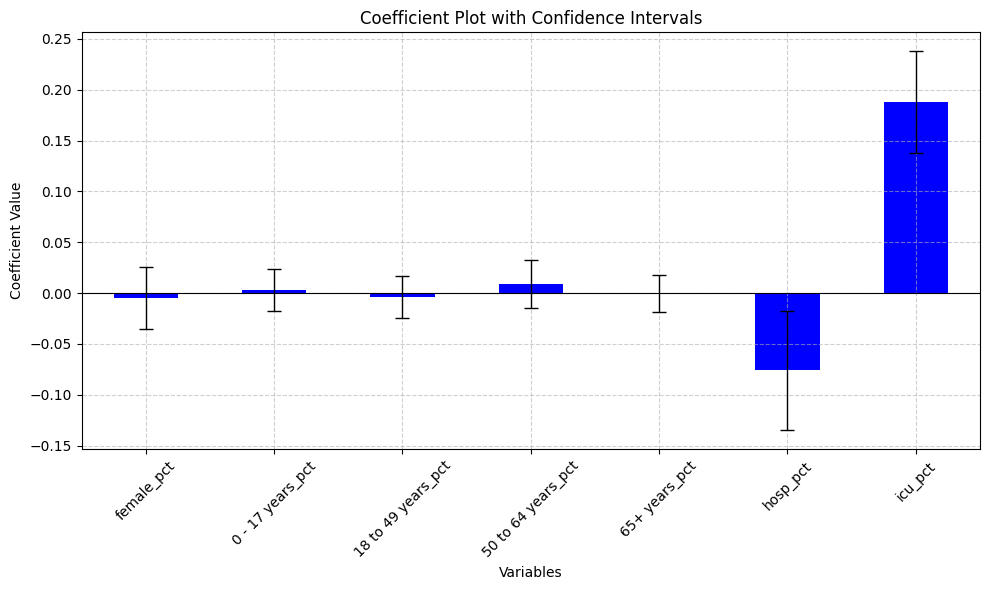

In [14]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd


# Extracting coefficients and confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int.columns = ['Lower CI', 'Upper CI']

# Create a DataFrame to hold coefficients and their confidence intervals
coef_df = pd.DataFrame({'Coefficient': coefficients, 'Lower CI': conf_int['Lower CI'], 'Upper CI': conf_int['Upper CI']})
coef_df = coef_df.drop('const', errors='ignore')  # Drop the intercept term if present for visualization purposes

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
coef_df['Coefficient'].plot(kind='bar', color='blue', ax=ax, yerr=(coef_df['Coefficient'] - coef_df['Lower CI'], coef_df['Upper CI'] - coef_df['Coefficient']), error_kw=dict(lw=1, capsize=5, capthick=1))
ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Variables')
ax.set_title('Coefficient Plot with Confidence Intervals')
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
